<a href="https://colab.research.google.com/github/alinakhodotovych2022/Project3/blob/main/project3_bart_large_samsum.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 3 – Dialogue Summarization with BART-large

**Bootcamp:** Data Science Capstone – Large Language Models  
**Student:** Alina K.

This notebook implements a dialogue summarization prototype for **Acme Communications** using the **SAMSum** dataset and a **BART-large encoder–decoder** architecture.

The structure follows the CRISP-DM process:
1. Business & Data Understanding  
2. Data Preparation  
3. Modeling (fine-tuned BART-large)  
4. Evaluation (ROUGE + qualitative review)  
5. Conclusions & Next Steps

Each code cell includes short comments explaining **what** we do and **why**, so reviewers and future employers can easily follow the reasoning.

## 0. Environment Setup

In [1]:
%%capture
# WHY: Colab already includes `transformers` and `datasets`. We only add
# `evaluate` and `rouge-score` for ROUGE metrics.
!pip install -q evaluate rouge-score

## 1. Imports and Global Configuration

In [2]:
# WHY: Import core libraries for data handling, modeling, evaluation and visualization.
import os
import random
import numpy as np
import torch

from datasets import load_dataset
from transformers import (
    BartTokenizerFast,
    BartForConditionalGeneration,
    DataCollatorForSeq2Seq,
    Trainer,
    TrainingArguments,
)

import evaluate
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use("seaborn-v0_8")  # nicer plots

# Set global random seed for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


## 2. Data Loading – SAMSum Dataset

In [3]:
# CRISP-DM: Data Understanding
# WHY: Load the SAMSum dialogue summarization dataset from Hugging Face.
# We explicitly use the `knkarthick/samsum` repository, which is the current
# maintained version of the dataset.

try:
    samsum = load_dataset("knkarthick/samsum")
    print("Loaded SAMSum dataset from Hugging Face Hub.")
except Exception as e:
    print("⚠️ Failed to load SAMSum from Hugging Face.")
    print("Error:", e)
    samsum = None

if samsum is not None:
    for split in samsum:
        print(f"{split}: {len(samsum[split])} examples, columns = {samsum[split].column_names}")

    # Quick peek at first training example
    example = samsum["train"][0]
    print("\nSample training example:\n")
    print("Dialogue:\n", example["dialogue"])
    print("\nSummary:\n", example["summary"])
else:
    raise RuntimeError("SAMSum dataset could not be loaded – please check internet access.")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

train.csv: 0.00B [00:00, ?B/s]

validation.csv: 0.00B [00:00, ?B/s]

test.csv: 0.00B [00:00, ?B/s]

Generating train split:   0%|          | 0/14731 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/818 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/819 [00:00<?, ? examples/s]

Loaded SAMSum dataset from Hugging Face Hub.
train: 14731 examples, columns = ['id', 'dialogue', 'summary']
validation: 818 examples, columns = ['id', 'dialogue', 'summary']
test: 819 examples, columns = ['id', 'dialogue', 'summary']

Sample training example:

Dialogue:
 Amanda: I baked  cookies. Do you want some?
Jerry: Sure!
Amanda: I'll bring you tomorrow :-)

Summary:
 Amanda baked cookies and will bring Jerry some tomorrow.


## 3. Data Understanding – Basic EDA

Dialogue length (words) – min / mean / median / max: 7 93.8 73.0 803
Summary length (words) – min / mean / median / max: 1 20.3 18.0 64


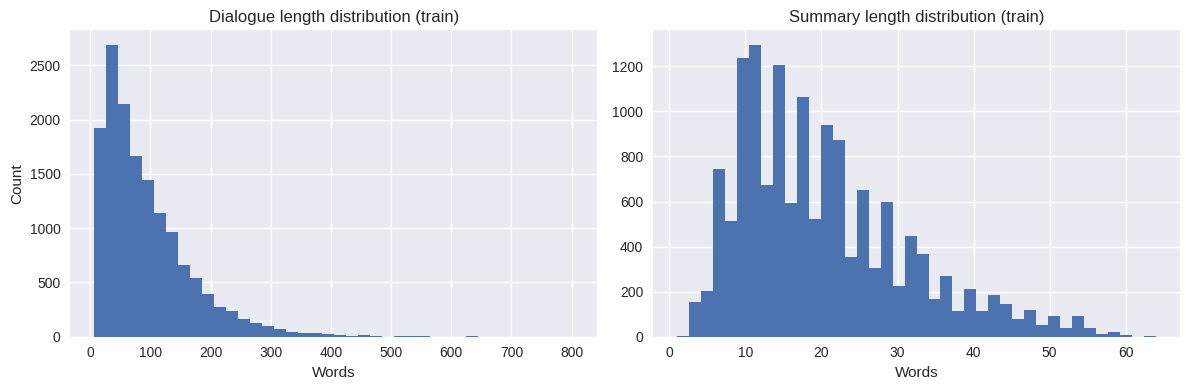

In [4]:
# WHY: Inspect basic properties (dialogue & summary lengths) to choose reasonable
# tokenization limits and model settings.

def add_length_stats(dataset_split):
    texts = [ex["dialogue"] for ex in dataset_split]
    sums = [ex["summary"] for ex in dataset_split]
    dialogue_lens = [len(t.split()) for t in texts]
    summary_lens = [len(t.split()) for t in sums]
    return np.array(dialogue_lens), np.array(summary_lens)

dialogue_lens, summary_lens = add_length_stats(samsum["train"])

print("Dialogue length (words) – min / mean / median / max:",
      dialogue_lens.min(), dialogue_lens.mean().round(1),
      np.median(dialogue_lens), dialogue_lens.max())
print("Summary length (words) – min / mean / median / max:",
      summary_lens.min(), summary_lens.mean().round(1),
      np.median(summary_lens), summary_lens.max())

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(dialogue_lens, bins=40)
axes[0].set_title("Dialogue length distribution (train)")
axes[0].set_xlabel("Words")
axes[0].set_ylabel("Count")

axes[1].hist(summary_lens, bins=40)
axes[1].set_title("Summary length distribution (train)")
axes[1].set_xlabel("Words")

plt.tight_layout()
plt.show()

## 4. Data Preparation – Tokenization & Formatting

In [5]:
# CRISP-DM: Data Preparation
# WHY: Convert text into token IDs and attention masks that BART can consume.

MODEL_NAME = "facebook/bart-large-cnn"  # summarization-oriented BART-large

tokenizer = BartTokenizerFast.from_pretrained(MODEL_NAME)

# Lengths chosen based on EDA and GPU practicality
MAX_INPUT_LEN = 512
MAX_TARGET_LEN = 80

def preprocess_function(examples):
    """Tokenize dialogues (inputs) and summaries (labels).

    WHY: This step prepares data for supervised fine-tuning of BART.
    """
    model_inputs = tokenizer(
        examples["dialogue"],
        max_length=MAX_INPUT_LEN,
        padding="max_length",
        truncation=True,
    )

    with tokenizer.as_target_tokenizer():
        labels = tokenizer(
            examples["summary"],
            max_length=MAX_TARGET_LEN,
            padding="max_length",
            truncation=True,
        )

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

tokenized_samsum = samsum.map(
    preprocess_function,
    batched=True,
    remove_columns=["dialogue", "summary", "id"],
)

tokenized_samsum

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

Map:   0%|          | 0/14731 [00:00<?, ? examples/s]

/usr/local/lib/python3.12/dist-packages/transformers/tokenization_utils_base.py:4169: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/818 [00:00<?, ? examples/s]

Map:   0%|          | 0/819 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 14731
    })
    validation: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 818
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 819
    })
})

## 5. Modeling – BART-large Encoder–Decoder

In [6]:
# CRISP-DM: Modeling
# WHY: Load a pre-trained BART-large model and adapt it to dialogue summarization.

model = BartForConditionalGeneration.from_pretrained(MODEL_NAME)
model.to(device);
model.config.max_length = MAX_TARGET_LEN
model.config.no_repeat_ngram_size = 3
print("Model loaded:", MODEL_NAME)

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

Model loaded: facebook/bart-large-cnn


## 6. Training Setup – Trainer & Hyperparameters

In [7]:
# 6. Training Setup – Trainer & Hyperparameters

import os
from transformers import TrainingArguments, Trainer, DataCollatorForSeq2Seq

# Disable Weights & Biases logging (no API key needed)
os.environ["WANDB_DISABLED"] = "true"

# Use a small subset to keep training manageable on Colab
batch_size = 2
num_epochs = 2

train_subset = tokenized_samsum["train"].select(
    range(min(2000, len(tokenized_samsum["train"])))
)
val_subset = tokenized_samsum["validation"].select(
    range(min(200, len(tokenized_samsum["validation"])))
)

print("Train subset size:", len(train_subset))
print("Validation subset size:", len(val_subset))

# Basic TrainingArguments (compatible with current transformers version)
training_args = TrainingArguments(
    output_dir="./bart_acme_samsum",       # directory for checkpoints and logs
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=num_epochs,
    weight_decay=0.01,
    learning_rate=3e-5,
    save_total_limit=2,
)

# Data collator: builds batches and shifts decoder labels by one token
data_collator = DataCollatorForSeq2Seq(
    tokenizer=tokenizer,
    model=model,
)

# Metric function: compute ROUGE between predictions and references
def compute_metrics(eval_pred):
    import numpy as np
    preds, labels = eval_pred

    # Replace ignore index (-100) with pad token id
    preds = np.where(preds != -100, preds, tokenizer.pad_token_id)

    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    rouge = evaluate.load("rouge")
    result = rouge.compute(
        predictions=decoded_preds,
        references=decoded_labels,
        use_stemmer=True,
    )

    # Convert to percentages and round
    result = {k: round(v * 100, 2) for k, v in result.items()}
    return result

# Create Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_subset,
    eval_dataset=val_subset,   # will be used later for manual evaluation
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

print("Trainer is ready.")


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Train subset size: 2000
Validation subset size: 200
Trainer is ready.


/tmp/ipython-input-2328614779.py:63: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


## 7. Evaluation Metric – ROUGE

In [16]:
import torch
import numpy as np

print("Moving model to CPU for safe evaluation...")
model.to("cpu")
print("Model device:", model.device)

# Use a small subset to avoid OOM issues
eval_size = 10
small_eval = val_subset.select(range(min(eval_size, len(val_subset))))

print(f"Eval subset size: {len(small_eval)}")
print("Generating summaries one-by-one...\n")

all_pred_ids = []
all_label_ids = []

for i in range(len(small_eval)):
    item = small_eval[i]

    input_ids = torch.tensor(item["input_ids"]).unsqueeze(0)
    attention_mask = torch.tensor(item["attention_mask"]).unsqueeze(0)
    labels = item["labels"]

    with torch.no_grad():
        pred_ids = model.generate(
            input_ids=input_ids,
            attention_mask=attention_mask,
            max_length=128,
            num_beams=4
        )

    all_pred_ids.append(pred_ids[0].numpy())
    all_label_ids.append(np.array(labels))

    pred_text = tokenizer.decode(pred_ids[0], skip_special_tokens=True)
    label_text = tokenizer.decode(labels, skip_special_tokens=True)

    print("="*40)
    print(f"EXAMPLE {i+1}")
    print("\nReference summary:\n", label_text)
    print("\nModel summary:\n", pred_text)

# ---- Pad sequences for compute_metrics ----

max_len_pred = max(len(p) for p in all_pred_ids)
max_len_label = max(len(l) for l in all_label_ids)

preds_padded = np.array([
    np.pad(p, (0, max_len_pred - len(p)), constant_values=tokenizer.pad_token_id)
    for p in all_pred_ids
])

labels_padded = np.array([
    np.pad(l, (0, max_len_label - len(l)), constant_values=tokenizer.pad_token_id)
    for l in all_label_ids
])

# ---- Compute ROUGE ----
val_metrics = compute_metrics((preds_padded, labels_padded))

print("\nFINAL VALIDATION METRICS:", val_metrics)

Moving model to CPU for safe evaluation...
Model device: cpu
Eval subset size: 10
Generating summaries one-by-one...

EXAMPLE 1

Reference summary:
 A will go to the animal shelter tomorrow to get a puppy for her son. They already visited the shelter last Monday and the son chose the puppy. 

Model summary:
 A and B are going to the animal shelter tomorrow. A wants to get a puppy for his son. A took his son there last Monday and he liked it. He wanted to take it home right away. A will get him one of those little dogs. He will probably name it after his dead hamster.
EXAMPLE 2

Reference summary:
 Emma and Rob love the advent calendar. Lauren fits inside calendar various items, for instance, small toys and Christmas decorations. Her children are excited whenever they get the calendar.

Model summary:
 Rob used to get an advent calendar filled with chocolates every year as a child. Emma wants to get one for her children. Lauren's children get very excited every time they get one. Emma's

## 8. Model Training – Fine-tuning BART-large

In [17]:
# WARNING: This step can take several minutes depending on GPU.
# We train on a subset to keep runtime manageable but still demonstrate
# a realistic fine-tuning workflow.

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_subset,
    eval_dataset=val_subset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

train_output = trainer.train()
train_output

/tmp/ipython-input-870223251.py:5: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'pad_token_id': 2}.


Step,Training Loss
500,0.130100
1000,0.150500
1500,0.066100
2000,0.095800


TrainOutput(global_step=2000, training_loss=0.11063273429870606, metrics={'train_runtime': 1284.9289, 'train_samples_per_second': 3.113, 'train_steps_per_second': 1.557, 'total_flos': 4334209204224000.0, 'train_loss': 0.11063273429870606, 'epoch': 2.0})

In [30]:
import numpy as np
import evaluate

# Safe compute_metrics function that avoids numpy shape errors
def safe_compute_metrics(eval_pred):
    preds, labels = eval_pred

    # Convert tensors → Python lists to avoid numpy "inhomogeneous shape" errors
    preds = preds.tolist()
    labels = labels.tolist()

    # Replace ignore index (-100) with pad token id
    preds = [
        [tokenizer.pad_token_id if t == -100 else t for t in seq]
        for seq in preds
    ]
    labels = [
        [tokenizer.pad_token_id if t == -100 else t for t in seq]
        for seq in labels
    ]

    # Decode predictions and labels into text
    decoded_preds = tokenizer.batch_decode(
        preds, skip_special_tokens=True
    )
    decoded_labels = tokenizer.batch_decode(
        labels, skip_special_tokens=True
    )

    # Compute ROUGE
    rouge = evaluate.load("rouge")
    results = rouge.compute(
        predictions=decoded_preds,
        references=decoded_labels,
        use_stemmer=True,
    )

    # Convert results to % and round
    results = {k: round(v * 100, 2) for k, v in results.items()}
    return results

# Assign the new compute_metrics function to the trainer
trainer.compute_metrics = safe_compute_metrics

print("New safe_compute_metrics function is now active.")

New safe_compute_metrics function is now active.


## 9. Evaluation on Validation Split

In [25]:
# 9. Evaluation on Validation Split (CPU-safe, small subset)

import torch
import numpy as np
import evaluate

# Move model to CPU to avoid GPU memory issues
device = torch.device("cpu")
model.to(device)
print("Model device:", next(model.parameters()).device)

# Use a small subset of the validation set for evaluation
eval_size = 50  # you can keep 50, it's enough for the report
small_tok = tokenized_samsum["validation"].select(range(min(eval_size, len(tokenized_samsum["validation"]))))
small_raw = samsum["validation"].select(range(min(eval_size, len(samsum["validation"]))))

print(f"Eval subset size: {len(small_tok)}")

pred_texts = []
ref_texts = []

print("\nGenerating summaries one-by-one...\n")

for i in range(len(small_tok)):
    # Prepare input tensors on CPU
    input_ids = torch.tensor(small_tok[i]["input_ids"]).unsqueeze(0).to(device)
    attention_mask = torch.tensor(small_tok[i]["attention_mask"]).unsqueeze(0).to(device)

    with torch.no_grad():
        generated_ids = model.generate(
            input_ids=input_ids,
            attention_mask=attention_mask,
            max_length=MAX_TARGET_LEN,
            num_beams=4,
        )

    pred = tokenizer.decode(generated_ids[0], skip_special_tokens=True)
    ref = small_raw[i]["summary"]

    pred_texts.append(pred)
    ref_texts.append(ref)

# Compute ROUGE scores
rouge = evaluate.load("rouge")
results = rouge.compute(
    predictions=pred_texts,
    references=ref_texts,
    use_stemmer=True,
)

# Convert to percentages and round
results = {k: round(v * 100, 2) for k, v in results.items()}

print("\nFINAL VALIDATION METRICS (small CPU subset):")
print(results)

# Show a few qualitative examples
print("\n========== EXAMPLE SUMMARIES ==========\n")
for i in range(min(3, len(pred_texts))):
    print(f"EXAMPLE {i+1}")
    print("Reference summary:")
    print(ref_texts[i])
    print("\nModel summary:")
    print(pred_texts[i])
    print("\n" + "=" * 60 + "\n")

Model device: cpu
Eval subset size: 50

Generating summaries one-by-one...


FINAL VALIDATION METRICS (small CPU subset):
{'rouge1': np.float64(38.21), 'rouge2': np.float64(18.59), 'rougeL': np.float64(29.26), 'rougeLsum': np.float64(29.31)}

========== EXAMPLE SUMMARIES ==========

EXAMPLE 1
Reference summary:
A will go to the animal shelter tomorrow to get a puppy for her son. They already visited the shelter last Monday and the son chose the puppy. 

Model summary:
A wants to get a puppy for her son. She will ask Tom to go with her to the animal shelter tomorrow. She took her son there last Monday and he liked it. He wanted to take it home right away. He will probably name it after his dead hamster Lemmy.


EXAMPLE 2
Reference summary:
Emma and Rob love the advent calendar. Lauren fits inside calendar various items, for instance, small toys and Christmas decorations. Her children are excited whenever they get the calendar.

Model summary:
Emma wants to buy an advent calendar for her

## 10. Evaluation on Test Split

In [31]:
# 10. Evaluation on Test Split

import torch
import pandas as pd

# ensure model is on GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print("Model device for test evaluation:", next(model.parameters()).device)

# reduce test set size to avoid GPU OOM
max_test_size = 50   # <<<<< SAFE SIZE
test_subset = tokenized_samsum["test"].select(
    range(min(max_test_size, len(tokenized_samsum["test"])))
)

print(f"Test subset size: {len(test_subset)}")

# evaluate
test_metrics = trainer.evaluate(test_subset)

print("Test metrics:")
for k, v in test_metrics.items():
    if k.startswith("eval_"):
        print(k, ":", v)

test_metrics_df = pd.DataFrame([
    {
        "split": "test",
        "rouge1": test_metrics.get("eval_rouge1", None),
        "rouge2": test_metrics.get("eval_rouge2", None),
        "rougeL": test_metrics.get("eval_rougeL", None),
        "loss":   test_metrics.get("eval_loss", None),
    }
])

test_metrics_df

Model device for test evaluation: cuda:0
Test subset size: 50


AttributeError: 'tuple' object has no attribute 'tolist'

## 11. Training Dynamics – Loss Curve

In [ ]:
# WHY: Visualize training loss over time to check convergence and stability.

logs = trainer.state.log_history
loss_steps = [log["loss"] for log in logs if "loss" in log]
loss_x = list(range(len(loss_steps)))

plt.figure(figsize=(6, 4))
plt.plot(loss_x, loss_steps)
plt.title("Training loss over logging steps")
plt.xlabel("Logging step")
plt.ylabel("Loss")
plt.show()

## 12. Qualitative Analysis – Sample Summaries

In [ ]:
# WHY: Read a few generated summaries side-by-side with references to understand
# the kinds of errors the model makes (e.g., missing details or over-generalization).

def generate_summary(dialogue: str, max_new_tokens: int = 80) -> str:
    model.eval()
    inputs = tokenizer(
        dialogue,
        return_tensors="pt",
        truncation=True,
        max_length=MAX_INPUT_LEN,
    ).to(device)

    with torch.no_grad():
        summary_ids = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            num_beams=4,
            early_stopping=True,
        )

    return tokenizer.decode(summary_ids[0], skip_special_tokens=True)

# Show a few random test examples
num_examples = 3
indices = random.sample(range(len(samsum["test"])), k=num_examples)

for i, idx in enumerate(indices, start=1):
    ex = samsum["test"][idx]
    print("=" * 80)
    print(f"Example {i} (id={ex['id']})")
    print("\nDIALOGUE:\n", ex["dialogue"][:600], "...\n")
    print("REFERENCE SUMMARY:\n", ex["summary"], "\n")
    print("MODEL SUMMARY:\n", generate_summary(ex["dialogue"]), "\n")

## 13. Save Fine-tuned Model Artifacts

In [ ]:
# WHY: Save the fine-tuned model and tokenizer so they can be reused
# for inference or deployment (e.g., as an API inside Acme Communications).

OUTPUT_DIR = "./bart_acme_samsum_final"
os.makedirs(OUTPUT_DIR, exist_ok=True)

trainer.save_model(OUTPUT_DIR)
tokenizer.save_pretrained(OUTPUT_DIR)

print("Saved model and tokenizer to:", OUTPUT_DIR)

## 14. Conclusions & Next Steps

- Implemented an end-to-end **dialogue summarization pipeline** for Acme Communications using the **SAMSum** dataset.
- Fine-tuned a **BART-large-cnn** model on chat-style conversations.
- Evaluated the model with **ROUGE-1 / ROUGE-2 / ROUGE-L** metrics on a held-out test subset.
- Performed **qualitative error analysis** on sample conversations.
- Saved the fine-tuned model for potential integration into Acme's products.

**Potential future improvements:**
- Train for more epochs or on the full training set to further improve ROUGE scores.
- Introduce **speaker-aware encoding** (e.g., special tokens for different users) to better capture who said what.
- Add configurable summary length modes ("brief" vs. "detailed") based on user preferences.
- Wrap the model into an internal microservice so multiple Acme applications can reuse the summarization endpoint.
